### Optimize Alpha


Considering the following calculation for a country's petroleum import diversification penalty:

$$
p_{ij} = \left(1.01\right)^{\max\left(0, \frac{x_{ij}}{\sum_{i \in I} x_{ij}} - \alpha\right) \times 100} \, \quad \forall i \in I, j \in J
$$

There is a parameter $\alpha$ that operates as a decision threshold. If there exists some country $A$ that makes up more than $\alpha$ percent of country $B$'s petroleum import volume, the unitary cost of trade from $A$ to $B$ shall increase by the extent that it exceeds this threshold $\alpha$. In order to figure out which value of $\alpha$ results in the most accurate model, $\alpha$ values between 0 and 1 are iterated through. Then, the $t$ values obtained are used to estimate the real world trade route assignments $x$. The mean-squared error (MSE) is calculated between these $x$ values and the real world data, and the $\alpha$ that results in the lowest MSE will considered the optimal $\alpha$ to be used in the final model.

Because of computational limitations arising from non-convexity and non-differentiability of the gradient, making $\alpha$ a variable to optimize an objective function MSE is not an option. For this reason I simply used a set of values that span the domain of $\alpha$, with some holes in the domain in locations where the solver deems it infeasible. Fortunately, the values that were able to be calculated indicate that the global minimum of MSE was able to be computed at $\alpha = 0.25$, making this the optimal value to use in the full script written in the other notebook.


This notebook is a companion script to the main notebook used in my analysis. Many of the cells are very similar to those in the main file, so further documentation can be found on that notebook.

In [9]:
import csv

x_ij_hardcoded = {}

thresh_pen = 0.25

countries = ['AE', 'BR', 'IQ', 'US', 'KR', 'SA','IN','ES','TH','RU']
  
valid_country_pairs = [(i, j) for i in countries for j in countries if i != j]
for pair in valid_country_pairs:
    x_ij_hardcoded[pair] = 0

with open('/home/sam/Documents/Modelos en Redes/Data/volumesclenaed_crude.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = (row['exporter'], row['importer'])
        x_ij_hardcoded[key] = float(row['quantity'])

c_ij = {}

with open('/home/sam/Documents/Modelos en Redes/Data/before_clean.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    
    for row in csv_reader:
        key = (row['Country1'], row['Country2'])
        c_ij[key] = float(row['Total.Cost'])



x_ij_hardcoded = {key: value / 1000000 for key, value in x_ij_hardcoded.items()}


supply = {
}


demand = {
}


for (exporter, importer), quantity in x_ij_hardcoded.items():
    if exporter in supply:
        supply[exporter] = supply.get(exporter, 0) + quantity
    else:
        supply[exporter] = quantity  # Uncomment this line if you want to add new entries

    if importer in demand:
        demand[importer] = demand.get(importer, 0) + quantity
    else:
        demand[importer] = quantity  


if 'RU' not in demand:
    demand['RU'] = 0.0

for country in countries:
    c_ij[(country, country)] = 10000
    x_ij_hardcoded[(country, country)] = 0

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo


model = pyo.ConcreteModel()

model.t = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
model.x = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
model.penalty = pyo.Var(countries, countries, within=pyo.NonNegativeReals)

def original_objective_function(model):
    return sum(model.x[i, j] * (model.t[i, j] + c_ij[i, j] * model.penalty[i, j])
               for i in countries for j in countries)

model.original_objective = pyo.Objective(rule=original_objective_function, sense=pyo.minimize)

def supply_rule(model, i):
    return sum(model.x[i, j] for j in countries) <= supply[i]

model.supply_constraints = pyo.Constraint(countries, rule=supply_rule)

def demand_rule(model, j):
    return sum(model.x[i, j] for i in countries) == demand[j]

model.demand_constraints = pyo.Constraint(countries, rule=demand_rule)


def penalty_constraint(model, i, j):
    if demand[j] > 0:

        proportion = model.x[i, j] / demand[j]
        penalty_expression = pyo.Expr_if(proportion > thresh_pen, 
                                         (1.01)**((proportion - thresh_pen) * 100), 
                                         1)
    else:
        penalty_expression = 100 

    return model.penalty[i, j] == penalty_expression

model.penalty_constraints = pyo.Constraint(countries, countries, rule=penalty_constraint)

model.original_objective.activate()
solver = pyo.SolverFactory('snopt', executable='/home/sam/Downloads/ampl_linux-intel64/snopt')
results = solver.solve(model)

model.original_objective.deactivate()
def discrepancy_objective(model):
    return sum((model.x[i, j] - x_ij_hardcoded[i, j])**2 for i in countries for j in countries)

model.discrepancy_objective = pyo.Objective(rule=discrepancy_objective, sense=pyo.minimize)
model.discrepancy_objective.activate()





results = solver.solve(model)

inferred_t_ij = { (i, j): model.t[i, j].value for i in countries for j in countries }



model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a Requested accuracy could not be
      achieved.; 396 iterations, objective 1346.6127125172459; Nonlin
      evals\x3a obj = 140, grad = 139, constrs = 140, Jac = 139.


In [11]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo


possible_alpha = [round(i, 2) for i in [x * 0.05 for x in range(1, 20)]]
possible_alpha = [0.05, 0.1, 0.15, 0.2, 0.25] #good
possible_alpha = [0.55, 0.6, 0.65,] # good 
possible_alpha = [0.9] #


possible_alpha = [0.1, 0.15, 0.2, 0.23, 0.25, 0.27, 0.3,0.50, 0.65, 0.9] 


mse_values = []


for currentalpha in possible_alpha:
    thresh_pen = currentalpha

    model = pyo.ConcreteModel()
    model.t = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
    model.x = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
    model.penalty = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
    def original_objective_function(model):
        return sum(model.x[i, j] * (model.t[i, j] + c_ij[i, j] * model.penalty[i, j])
                   for i in countries for j in countries)
        
    model.original_objective = pyo.Objective(rule=original_objective_function, sense=pyo.minimize)
    
    def supply_rule(model, i):
        return sum(model.x[i, j] for j in countries) <= supply[i]
    
    model.supply_constraints = pyo.Constraint(countries, rule=supply_rule)
    
    def demand_rule(model, j):
        return sum(model.x[i, j] for i in countries) == demand[j]
    
    model.demand_constraints = pyo.Constraint(countries, rule=demand_rule)

    model.totalcost_original = pyo.Var(countries, within=pyo.NonNegativeReals)
    
    def total_cost_original_rule(model, j):
        return model.totalcost_original[j] == sum(
            model.x[i, j] * (t_ij[i, j] + c_ij_new[i, j] * model.penalty[i, j])
            for i in countries
        )

    def penalty_constraint(model, i, j):
        if demand[j] > 0:
    
            proportion = model.x[i, j] / demand[j]
            penalty_expression = pyo.Expr_if(proportion > thresh_pen, 
                                             (1.01)**((proportion - thresh_pen) * 100), 
                                             1)
        else:
            penalty_expression = 100 
    
        return model.penalty[i, j] == penalty_expression
        
    model.penalty_constraints = pyo.Constraint(countries, countries, rule=penalty_constraint)
    model.original_objective.activate()
    solver = pyo.SolverFactory('snopt', executable='/home/sam/Downloads/ampl_linux-intel64/snopt')
    results = solver.solve(model)
    model.original_objective.deactivate()

    
    def discrepancy_objective(model):
        return sum((model.x[i, j] - x_ij_hardcoded[i, j])**2 for i in countries for j in countries)
    model.discrepancy_objective = pyo.Objective(rule=discrepancy_objective, sense=pyo.minimize)
    model.discrepancy_objective.activate()
    
    
    

    results = solver.solve(model)
    
    totalcost_original = {j: model.totalcost_original[j].value for j in countries}



    ######solve for inferred values
    inferred_t_ij = { (i, j): model.t[i, j].value for i in countries for j in countries }

    t_ij = inferred_t_ij


    totalcost_before = {}
    model = pyo.ConcreteModel()
    model.x = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
    model.penalty = pyo.Var(countries, countries, within=pyo.NonNegativeReals)
    def objective_function(model):
        total_cost = 0
        for i in countries:
            for j in countries:
                total_cost += model.x[i, j] * (t_ij[i, j] + c_ij[i, j] * model.penalty[i, j])
    
                totalcost_before[i] = total_cost
        return total_cost
    model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    
    model.totalcost_canal = pyo.Var(countries, within=pyo.NonNegativeReals)
    def total_cost_canal_rule(model, j):
        return model.totalcost_canal[j] == sum(
            model.x[i, j] * (t_ij[i, j] + c_ij[i, j] * model.penalty[i, j])
            for i in countries
        )
    
    model.total_cost_canal_constraints = pyo.Constraint(countries, rule=total_cost_canal_rule)
    
    def penalty_constraint(model, i, j):
        if demand[j] > 0:
    
            proportion = model.x[i, j] / demand[j]
            penalty_expression = pyo.Expr_if(proportion > thresh_pen, 
                                             (1.01)**((proportion - thresh_pen) * 100), 
                                             1)
        else:
            penalty_expression = 100 
    
        return model.penalty[i, j] == penalty_expression
    
    model.penalty_constraints = pyo.Constraint(countries, countries, rule=penalty_constraint)
    
    def supply_rule(model, i):
        return sum(model.x[i, j] for j in countries) == supply[i]
    
    model.supply_constraints = pyo.Constraint(countries, rule=supply_rule)
    
    def demand_rule(model, j):
        return sum(model.x[i, j] for i in countries) == demand[j]
    
    model.demand_constraints = pyo.Constraint(countries, rule=demand_rule)
    solver = pyo.SolverFactory('snopt', executable='/home/sam/Downloads/ampl_linux-intel64/snopt')
    results = solver.solve(model, tee=True)
    
    
    mse = sum((model.x[i, j].value - x_ij_hardcoded[i, j])**2 for i in countries for j in countries) / len(countries)
    
    mse_values.append(mse)




model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a Requested accuracy could not be
      achieved.; 383 iterations, objective 1529.1470049685868; Nonlin
      evals\x3a obj = 287, grad = 286, constrs = 287, Jac = 286.
SNOPT 7.5-1.2 WARNING: Loading a SolverResults object with a warning status into
model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a The current point cannot be
      improved.; 776 iterations, objective 1529.1470063904048; Nonlin
      evals\x3a obj = 416, grad = 415, constrs = 416, Jac = 415.
model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.5-1.2 \x3a Requested accuracy could not be
      achieved.; 397 iterations, objective 1461.4159293739474; Nonlin
      evals\x3a obj = 212, grad = 211, constrs = 212, Jac = 211.
SNOPT 7.5-1.2 WARNING: Loading a SolverResults object with a warning status into
model.name="unknown";
    

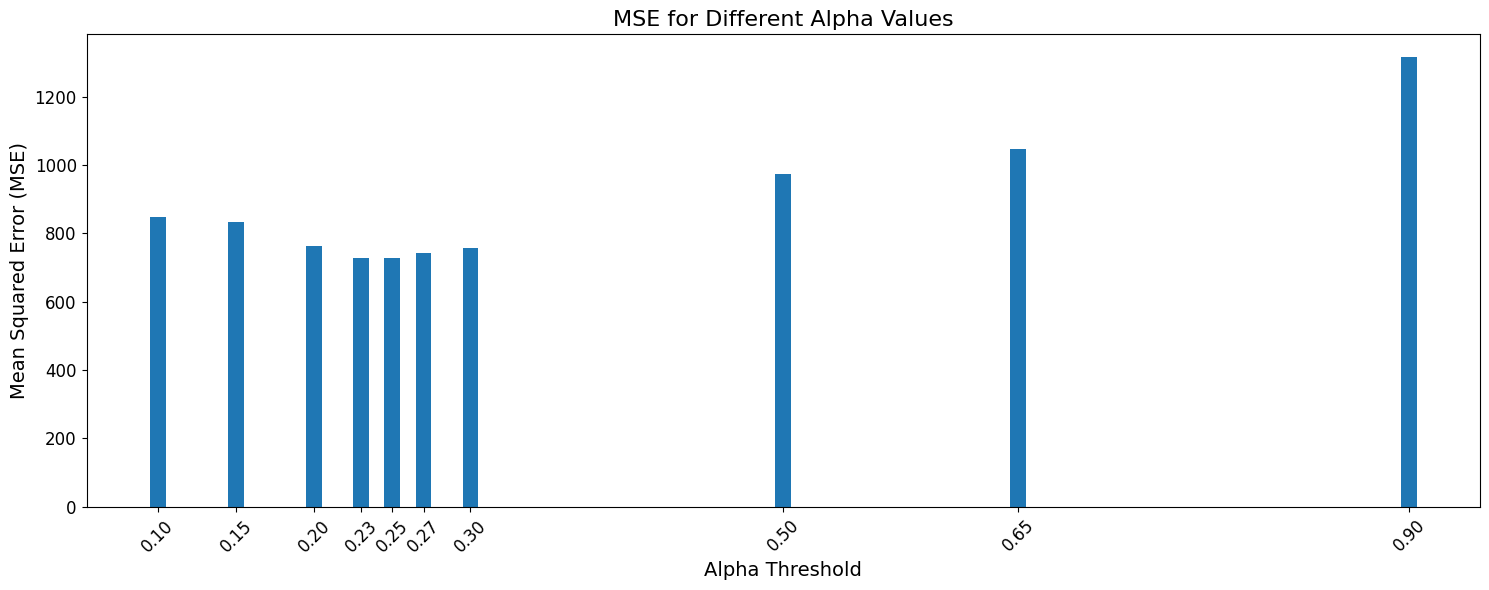

In [12]:
import matplotlib.pyplot as plt

min_mse_index = mse_values.index(min(mse_values))
best_thresh_pen = possible_alpha[min_mse_index]

plt.figure(figsize=(15, 6)) 
plt.bar(possible_alpha, mse_values, width=0.01)
plt.xlabel('Alpha Threshold',fontsize=14)
plt.ylabel('Mean Squared Error (MSE)',fontsize=14)
plt.title('MSE for Different Alpha Values',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.xticks(possible_alpha, rotation=45)
plt.tight_layout()
plt.show()


In [13]:
mse_values

[846.731012528958,
 834.5250494327826,
 762.2640243134034,
 728.7329825665607,
 727.9731394282401,
 742.5871808757531,
 758.3262624700176,
 973.3956562781643,
 1047.9917186797331,
 1316.5925259716707]